In [1]:
 
import pandas as pd 
import numpy as np
import yfinance
from IPython.display import HTML
import random
#from ipynb.fs.full.Functions1 import hide_toggle
#from operator import itemgetter 
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
#from mpl_finance import candlestick_ohlc
from mplfinance.original_flavor import candlestick_ohlc
import pandas_datareader as pdr
import datetime as dt
import talib
from itertools import compress
#from ipynb.fs.full.Hide import hide_toggle # this function has to be in the same directory!
# pip install finta!!! the only site that has inverse fisher transform!

In [ ]:
symbol ="AAPL TSLA MSFT SPY AMZN BABA GOOGL NFLX AAL PYPL COST"
num_name= symbol.split(' ') 
data_frames_separate = []
for i in num_name:
        ticker = yfinance.Ticker(i)
        data=ticker.history(interval='1d',start="2019-01-01",end="2021-02-05")
        data['Date'] = pd.to_datetime(data.index) # just to crate another column for date!!!
        data['Date'] = data['Date'].apply(mpl_dates.date2num)
        data = data.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
        ohlc_data= data.loc[:,['Date', 'Open', 'High', 'Low', 'Close']].values
        data_frames_separate.append(data)


rsi_High = talib.RSI(data["High"])
rsi_Low= talib.RSI(data["Low"])
#rsi_open = talib.RSI(data["Open"])
rsi_closed= talib.RSI(data["Close"])
       
data_frames_separate[2]

In [ ]:
for i in range(len(num_name)):
     data_frames_separate[i]["RsiLow"]= talib.RSI(data_frames_separate[i]["Low"])
     data_frames_separate[i]["RsiHigh"]= talib.RSI(data_frames_separate[i]["High"])
data_frames_separate[5]

In [ ]:
for i in range(len(num_name)):
    data_frames_separate[i]["RSI"]= talib.RSI(data_frames_separate[i]["Close"])
    data_frames_separate[i]['Signal'] = 0.0
    data_frames_separate[i]['BuySignal'] = np.where((data_frames_separate[i]["RSI"] < 30)& (data_frames_separate[i]["RSI"] < 31), 1.0, 0.0)
    data_frames_separate[i]['SellSignal'] = np.where((data_frames_separate[i]["RSI"] >75) & (data_frames_separate[i]["RSI"] <76) , -1.0, 0.0)
    
data_frames_separate[5]

In [ ]:
# only for plotting!  this is unnecesarily long - u can just point to the columns!
rsi_data=[]
for i in range(len(num_name)):
    rsi_data.append(talib.RSI(data_frames_separate[i]["Close"]))
len(rsi_data)

In [ ]:
def isSupportRSI(df,i):
  support = df['RsiLow'][i] < df['RsiLow'][i-1]  and df['RsiLow'][i] < df['RsiLow'][i+1] \
  and df['RsiLow'][i+1] < df['RsiLow'][i+2] and df['RsiLow'][i-1] < df['RsiLow'][i-2]

  return support

def isResistanceRSI(df,i):
  resistance = df['RsiHigh'][i] > df['RsiHigh'][i-1]  and df['RsiHigh'][i] > df['RsiHigh'][i+1] \
  and df['RsiHigh'][i+1] > df['RsiHigh'][i+2] and df['RsiHigh'][i-1] > df['RsiHigh'][i-2] 

  return resistance

In [ ]:
levels = [[] for i in range(len(num_name))]
levels_only=[[] for i in range(len(num_name))]

for a in range(len(levels)):
    for i in range(2,data_frames_separate[a].shape[0]-2):
        if isSupportRSI(data_frames_separate[a],i):
            levels[a].append((i,data_frames_separate[a]['RsiLow'][i]))
            levels_only[a].append(data_frames_separate[a]['RsiLow'][i])

        elif isResistanceRSI(data_frames_separate[a],i):
            levels[a].append((i,data_frames_separate[a]['RsiHigh'][i]))
            levels_only[a].append(data_frames_separate[a]['RsiHigh'][i])

print(len(levels),len(levels_only))


In [ ]:
def plotRsiSupportResistance(num):
    
  fig = plt.figure(figsize=(12,8))
  gs = gridspec.GridSpec(2, 1, height_ratios = [2,1]) 
  ax_rsi1= plt.subplot(gs[0])    
  plt.title(num_name[num])

  candlestick_ohlc(ax_rsi1,data_frames_separate[num].values,width=0.6, \
                   colorup='green', colordown='red', alpha=0.8)


# plot ‘buy’ signals
  ax_rsi1.plot(data_frames_separate[num][data_frames_separate[num]['BuySignal'] == 1].index, 
             data_frames_separate[num]['Close'][data_frames_separate[num]['BuySignal'] == 1], 
              '^', markersize = 10, color = 'g', label = 'buy')
# plot ‘sell’ signals
  ax_rsi1.plot(data_frames_separate[num][data_frames_separate[num]['SellSignal'] == -1].index, 
             data_frames_separate[num]['Close'][data_frames_separate[num]['SellSignal'] == -1], 
             'v', markersize = 10, color = 'r', label = 'sell')


    
  ax_rsi= plt.subplot(gs[1],sharex=ax_rsi1)
 
  ax_rsi.plot(data.index, [75] * len(data.index))
  ax_rsi.plot(data.index, [30] * len(data.index))
  ax_rsi.plot(data.index, rsi_data[num])

  legend_labels= ["overbought", "oversold","rsi"]
  ax_rsi.legend(legend_labels,loc = 2)

  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax_rsi.xaxis.set_major_formatter(date_format)
  fig.autofmt_xdate()
  fig.tight_layout()
  ax_rsi1.grid()
  #ax_rsi.grid()
# Removing the date labels and ticks from the price subplot:
  ax_rsi1.get_xaxis().set_visible(False)
# Removing the gap between the plots:
  fig.subplots_adjust(hspace=0)
# Adding a horizontal line at the zero level in the ROC subplot:
  ax_rsi.axhline(20, color = (.5, .5, .5), linestyle = '--', alpha = 0.5)
# We can add labels to both vertical axis:
  ax_rsi1.set_ylabel("Price ($)")
  ax_rsi.set_ylabel("% RSI")

# plot ‘sell’ signals
  ax_rsi.plot(data_frames_separate[num][data_frames_separate[num]['SellSignal'] == -1].index, 
              data_frames_separate[num]['RSI'][data_frames_separate[num]['SellSignal'] == -1], 
              'v', markersize = 10, color = 'r', label = 'sell')
# plot ‘buy’ signals
  ax_rsi.plot(data_frames_separate[num][data_frames_separate[num]['BuySignal'] == 1].index, 
              data_frames_separate[num]['RSI'][data_frames_separate[num]['BuySignal'] == 1], 
               '^', markersize = 10, color = 'g', label = 'buy')

  for level in levels[num]:
     plt.hlines(level[1],xmin=data_frames_separate[num]['Date'][level[0]],\
               xmax=max(data_frames_separate[num]['Date']),colors='blue')


In [ ]:
for i in range(len(num_name)):
    plotRsiSupportResistance(i)

In [12]:
# s=[]
# for num in range(len(num_name)):
#     s.append(np.mean(data_frames_separate[num]['RsiHigh'] - data_frames_separate[num]['RsiLow']))
   
# s

In [13]:
#  s= [abs(i)*10 for i in s]
s = 7 # make them all al least 5 !!!

In [14]:
# it is crazy how certain "S"values can be negative!! especially for tesla 

In [15]:
def isFarFromLevel(l,m):

  return np.sum([abs(l-x) < s  for x in levels[m]]) == 0

In [40]:
for i in range(len(levels_only)):
    print(max(levels_only[i]),min(levels_only[i]))

85.32698801357535 23.23239400358252
92.81723621874501 21.64305619182664
88.91217156149864 28.616470525755954
89.16434060570579 15.822246122905268
84.84892010638839 23.24705714984706
82.97081678336465 20.065879924150618
80.27076480583503 18.146871392418443
79.47316382996745 24.15798713769877
82.83457391667014 14.53864253227805
83.39403357449707 25.631632547201665
86.10966357050097 21.595616727597577


In [ ]:
for i in range(len(levels_only)):
    print(max(levels_only[i]),min(levels_only[i]))

In [17]:
levels = [[] for i in range(len(num_name))]
for num in range(len(levels)):
    for i in range(2,data_frames_separate[0].shape[0]-2):
            if isSupportRSI(data_frames_separate[0],i):
                l = data_frames_separate[0]['RsiLow'][i]

                if isFarFromLevel(l,num):
                      levels[num].append((i,l))

            elif isResistanceRSI(data_frames_separate[0],i):
                l = data_frames_separate[0]['RsiHigh'][i]

                if isFarFromLevel(l,num):
                      levels[num].append((i,l))
len(levels)

11

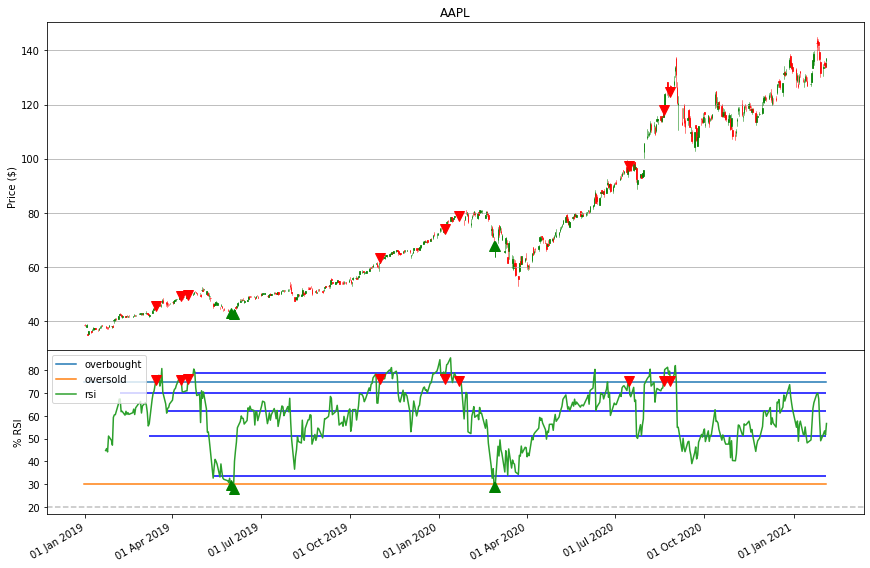

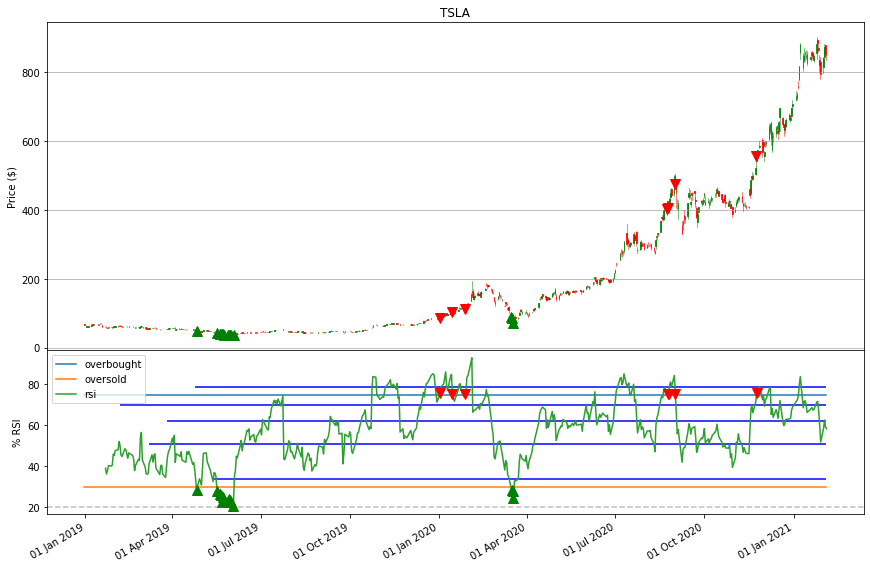

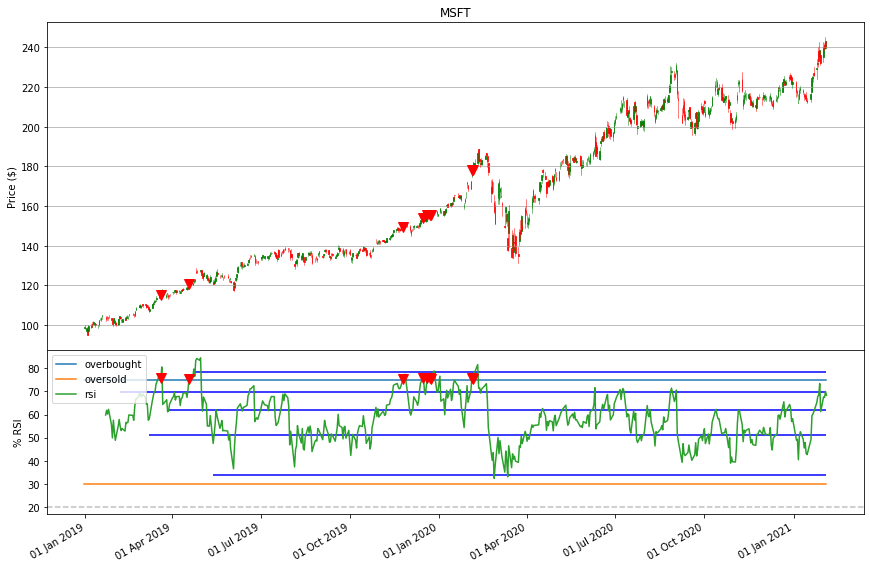

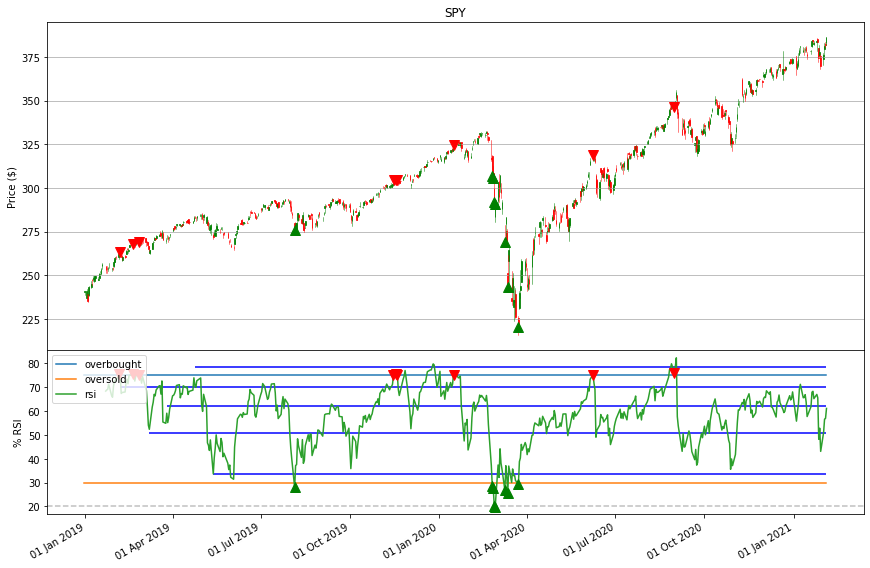

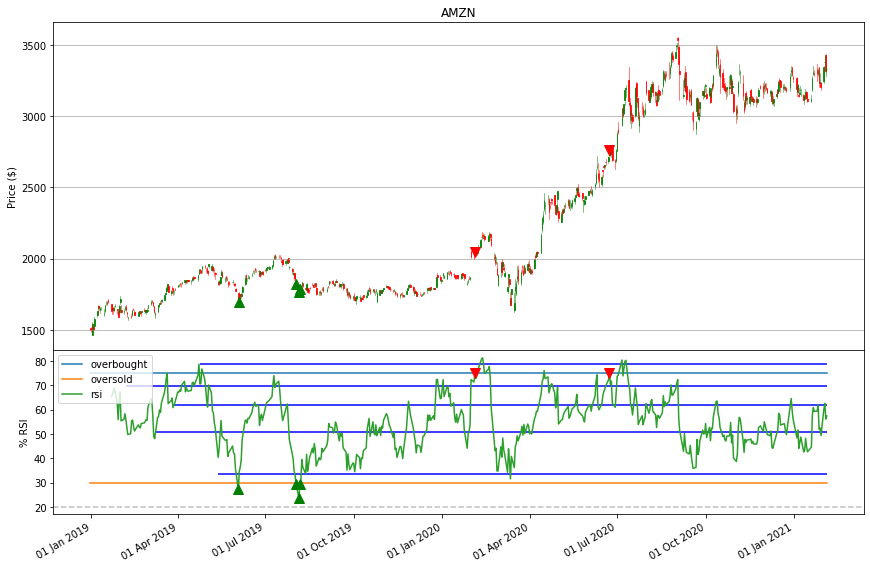

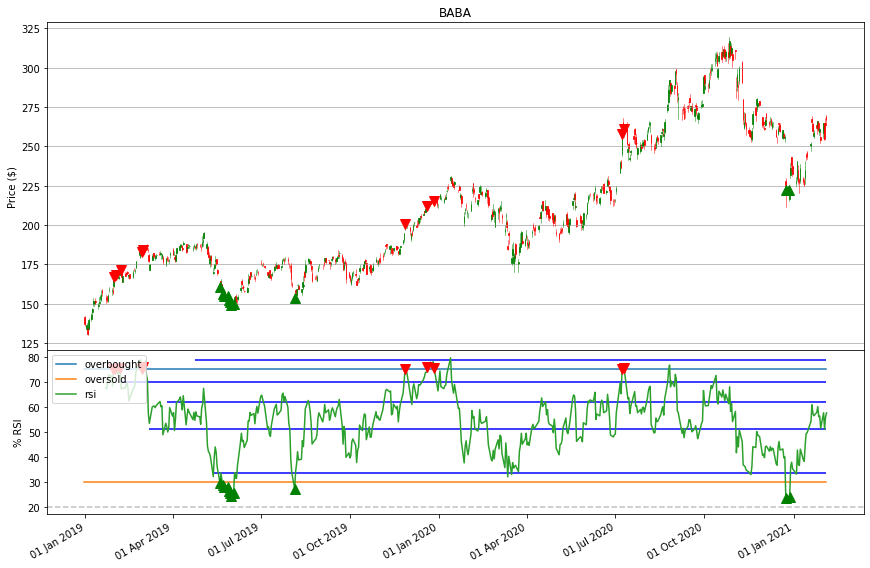

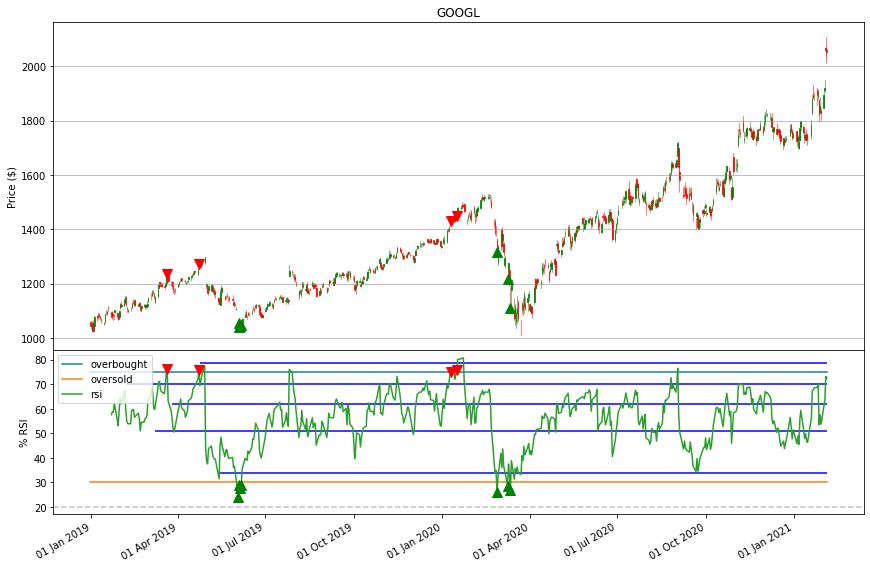

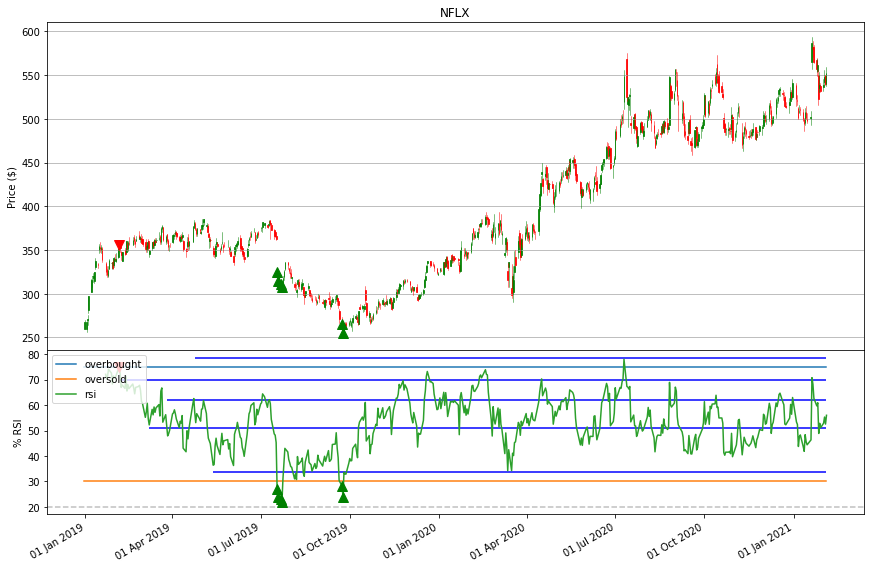

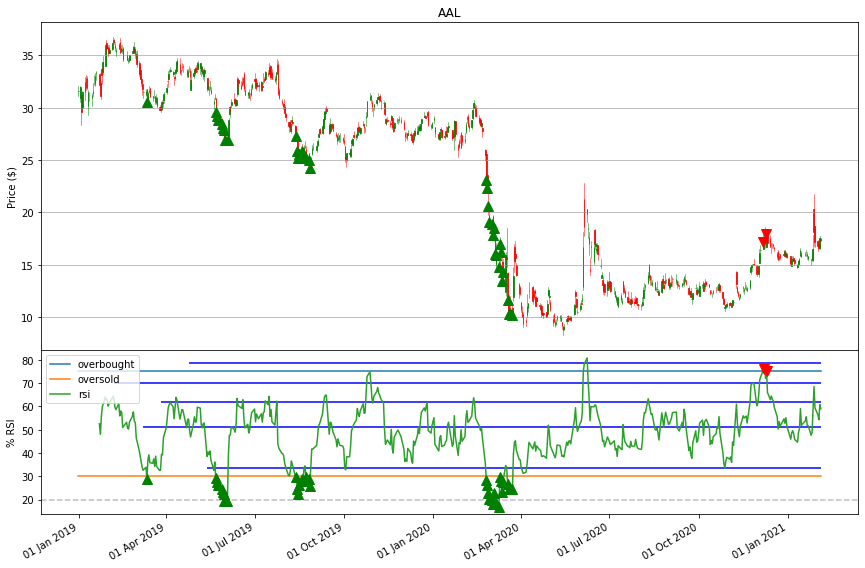

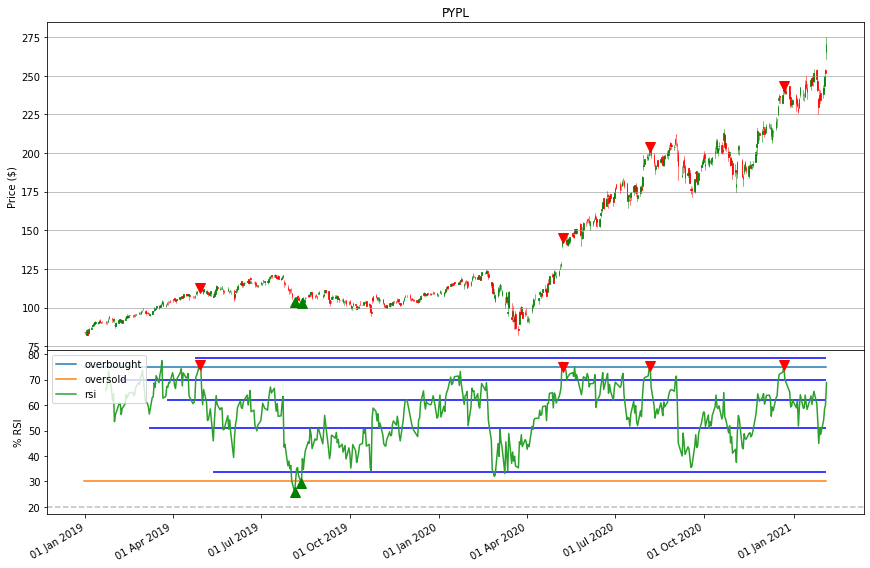

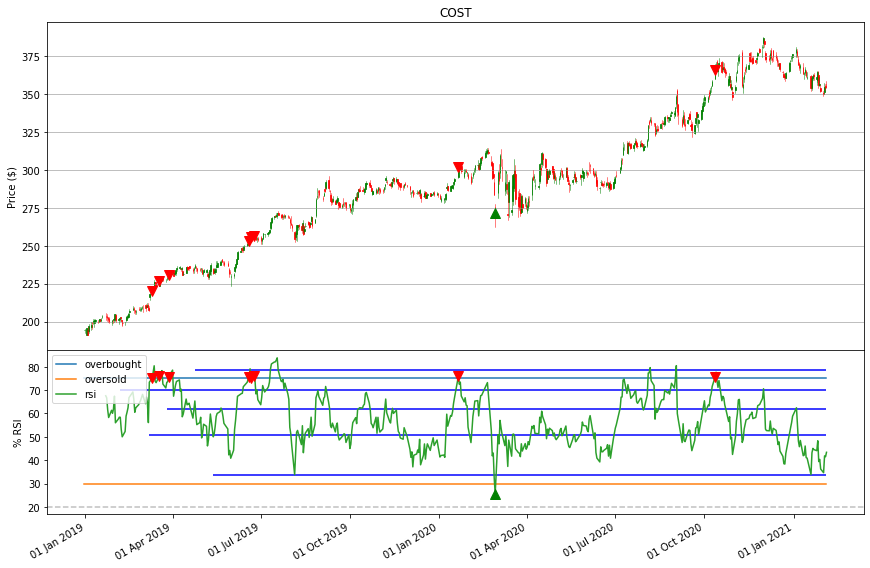

In [18]:
for i in range(len(num_name)):
    plotRsiSupportResistance(i)